# Splitting and Cross-validation

## Lecture Learning Objectives 

- Explain the concept of generalization.
- Split a dataset into train and test sets using `train_test_split` function.
- Explain the difference between train, validation, test, and "deployment" data.
- Identify the difference between training error, validation error, and test error.
- Explain cross-validation and use `cross_val_score()` and `cross_validate()` to calculate cross-validation error.
- Explain overfitting, underfitting, and the fundamental tradeoff.
- State the golden rule and identify the scenarios when it's violated.

## Five Minute Recap/ Lightning Questions 

- What is an example of machine learning? 
- Which type of machine learning does not have labels?
- What is an example of a Regression problem? 
- In a dataframe, what is an observation? 
- What is the first node of a Decision Tree called?
- Where/who determines the parameter values?
- What library will we be using for machine learning? 

Let's start by creating a decision tree model as we did in lecture 1.

In [1]:
# import a custom function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import altair as alt
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.append(os.path.join(os.path.abspath("."), "code"))
from plotting_functions import *
from utils import *

In [2]:
voting_df = pd.read_csv(
    'data/cities_USA.csv',
    index_col=0
).query(
    'lon > -140'  # Remove alaska for easier plotting
)
voting_df

,lon,lat,vote
1,-80.162475,25.692104,red
2,-80.214360,25.944083,red
3,-80.094133,26.234314,red
4,-80.248086,26.291902,red
5,-81.789963,26.348035,red
...,...,...,...
393,-101.115061,47.640333,blue
394,-119.036728,47.926446,red
395,-102.142732,47.955970,blue
396,-97.460476,48.225094,blue


In [3]:
# feature table
X = voting_df.drop(columns='vote')

# the target variable
y = voting_df['vote']

# initiate model framework with a decision tree of max_depth 2
depth=2
model_d2 = DecisionTreeClassifier(max_depth=depth)

# training the model
model_d2.fit(X, y)

# Score the models overall accuracy on the training data
print("The accuracy of the model on the training data: %0.3f" % (model_d2.score(X, y)))


The accuracy of the model on the training data: 0.826


In [4]:
# Predict on new data
model_d2.predict(pd.DataFrame({'lon': [-75], 'lat': [56]}))

array(['red'], dtype=object)

## Big picture and motivation 

In machine learning we want to learn a mapping function from labeled data so that we can predict labels of **unlabeled** data. For example, suppose we want to build a spam filtering system.  We will take a large number of spam/non-spam messages from the past, learn patterns associated with spam/non-spam from them, and predict whether **a new incoming message** in someone's inbox is spam or non-spam based on these patterns. 

So we want to learn from the past but ultimately we want to apply it on the future email messages. 

**How can we generalize from what we've seen to what we haven't seen?** 

In this lecture, we'll see how machine learning tackles this question. 

## Generalization

### Visualizing model complexity using decision boundaries

In the last lecture, we saw that we could visualize the splitting of decision trees using either a tree diagram or a plot of decision boundaries.

Plotting the values, we see the two levels of splits indicated by our max_depth=2 hypterparameter.

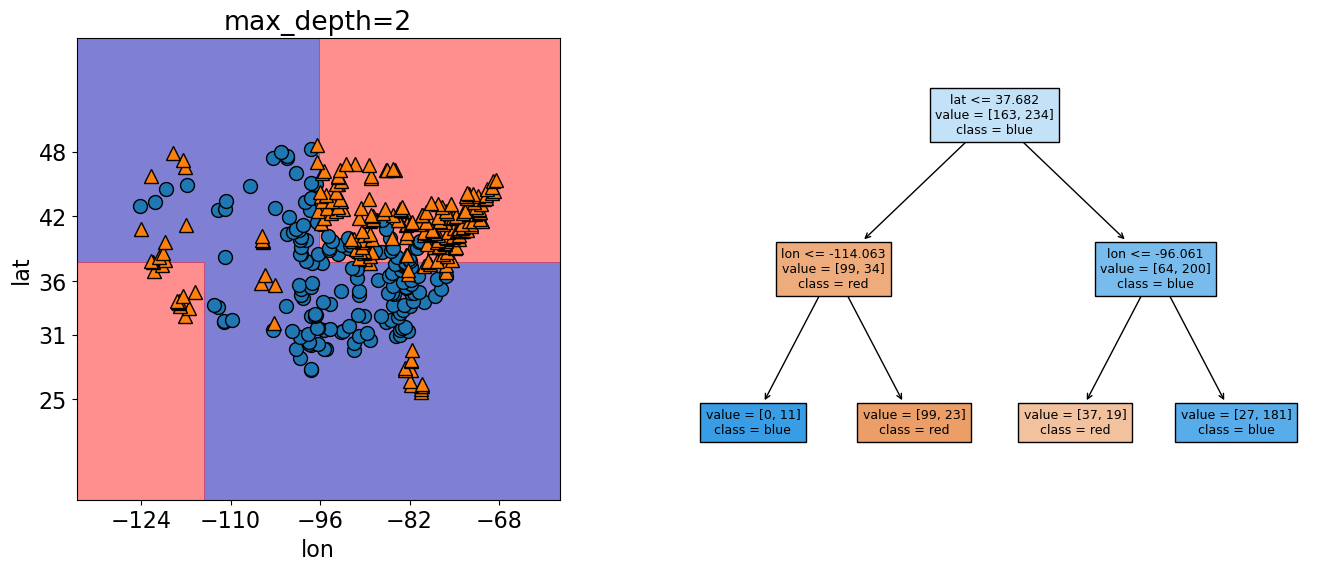

In [5]:
plot_tree_decision_boundary_and_tree(
    model_d2,
    X,
    y,
    eps=10,
    x_label="lon",
    y_label="lat",
)

Ok, now let's see what happens to our score and decision boundaries when we change our maximum tree depth.

In [6]:
depth = 3
model_d3 = DecisionTreeClassifier(max_depth=depth)
model_d3.fit(X, y)
print("The accuracy of the model on the training data: %0.3f" % (model_d3.score(X, y)))

The accuracy of the model on the training data: 0.874


The decision boundaries are created by three levels of splits now 3 splits now (for each observation we ask three questions to find out how to classify it).

Our score here has increased from 83% to 87%.

When we graph it, we can now see more boundaries, meaning that the model has become more specific to our training data.

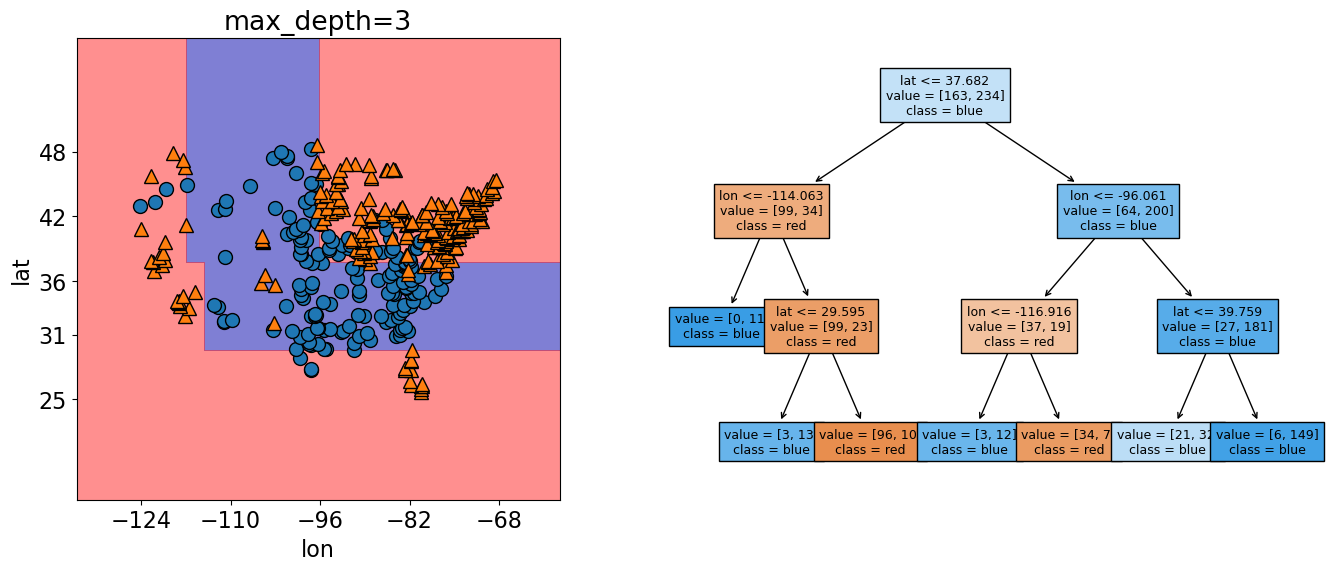

In [7]:
plot_tree_decision_boundary_and_tree(
    model_d3,
    X,
    y,
    eps=10,
    x_label="lon",
    y_label="lat",
)

What happens if we give the model an unlimited `max_depth`?

In [8]:
model_dmax = DecisionTreeClassifier()
model_dmax.fit(X, y);
model_dmax.get_depth()
print("The accuracy of the model on the training data: %0.3f" % (model_dmax.score(X, y)))

The accuracy of the model on the training data: 1.000


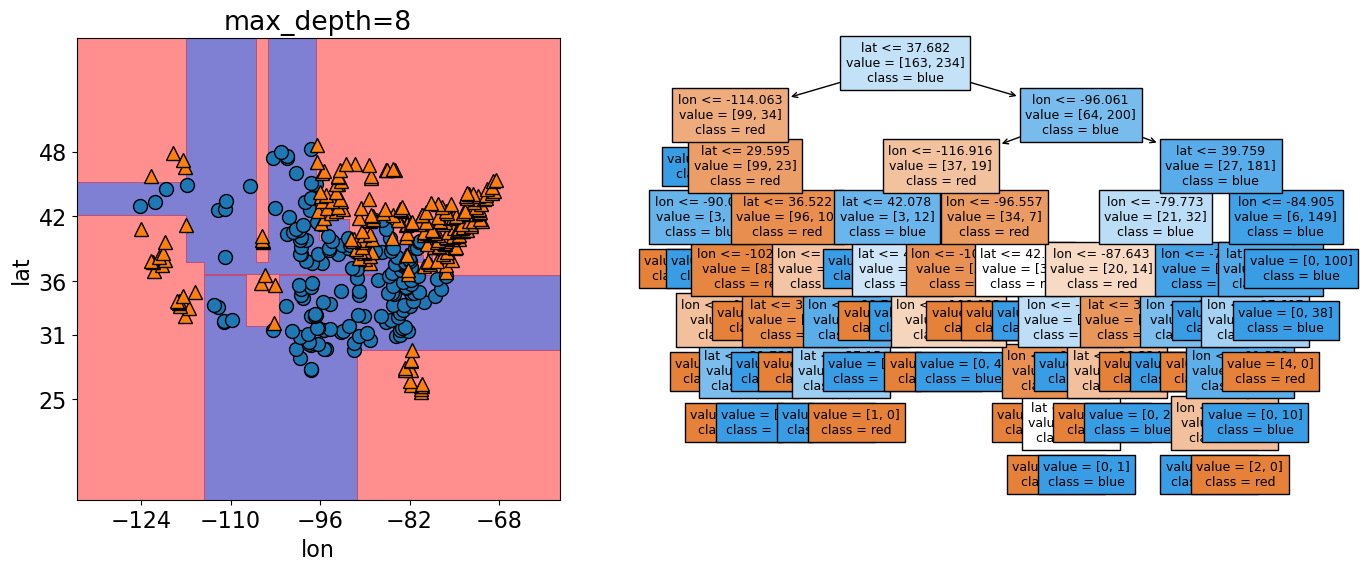

In [9]:
plot_tree_decision_boundary_and_tree(
    model_dmax,
    X,
    y,
    eps=10,
    x_label="lon",
    y_label="lat",
)

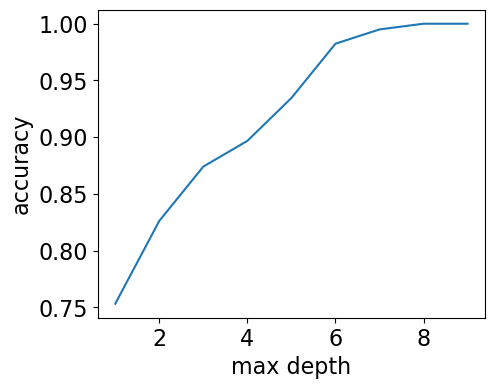

In [10]:
max_depths = np.arange(1, 10)
accuracies = []
for max_depth in max_depths:
    accuracy = (
        DecisionTreeClassifier(max_depth=max_depth).fit(X, y).score(X, y)
    )
    accuracies.append(accuracy)
plt.figure(figsize=(5, 4))
plt.plot(max_depths, accuracies)
plt.xlabel("max depth")
plt.ylabel("accuracy");

- Our model has 100% accuracy for depths >= 8!!
- Is it good or bad?
- How to pick the best max_depth?
- How can we make sure that the model we have built would do reasonably well on unseen data in the wild when it’s deployed?

We can see that we can reach 100% accuracy with models with max_depth >= 8. Does that mean we will ALWAYS get it right on unseen data?

We can use the cities from alaska that we excluded initially to find out:

In [11]:
alaska = pd.read_csv(
    'data/cities_USA.csv',
    index_col=0
).query(
    'lon <= -140'  
)
alaska

,lon,lat,vote
398,-166.519855,53.887114,blue
399,-163.733617,67.665859,blue
400,-145.423115,68.077395,blue


In [12]:
model_dmax.predict(alaska[['lon', 'lat']])

array(['red', 'red', 'red'], dtype=object)

Oh no! The model incorrectly predicted "red" for all three cities in Alaska.

This illustrates that a model that is more specific to the training data,
might not always generalize well to unseen data,
which is our eventual goal
since we will not have all its true target labels upfront
(then we would not need ML in the first place).

For our decision tree model,
we see that training score increases as we increase `max_depth`.
Since we are creating a more complex tree (higher `max_depth`)
we can fit all the peculiarities of our data to eventually get 100% accuracy.

### The Fundamental goal of machine learning

Goal: **to generalize beyond what we see in the training examples**. <br>
We are only given a sample of the data and do not have the full distribution. <br>
Using the training data, we want to come up with a reasonable model that will perform well on some unseen examples. <br>

At the end of the day, we want to deploy models that make reasonable predictions on unseen data


<!-- <img src='imgs/generalization-train.png'  width = "30%" alt="404 image" /> -->

### Generalizing to unseen data

<img src="imgs/generalization-predict.png" width = "100%" alt="404 image" />


- Goal: We want the model to be able to generalize beyond what it has seen in the training data.
- But these new examples should be representative of the training data. That is they should have the same characteristics as the training data.
- In this example, we would like the leaner to be able to predict labels for test examples 1, 2, and 3 accurately. Although 2, 3 don’t exactly occur in the training data, they are very much similar to the images in the training data. That said, is it fair to expect the learner to label image 4 correctly?


The point here is that we want this learning to be able to generalize beyond what it sees here and be able to predict and predict labels for the new examples that have some of the characteristics of, but are not identical too, the training data.

### Training score versus Generalization score (or Error)

So would we expect a model with a really high accuracy on the training data to perform equally well on unseen examples? Probably not. 

Hopefully our training data is representative of the unseen data, but it will not be identical. In general it is difficult to build a model that has close to perfect accuracy so when this happens on the training data, it might mean that we have made the model too specific to the training set.

Given a model in machine learning, people usually talk about two kinds of accuracies (scores):

1. Accuracy on the training data
    
2. **Accuracy on the entire distribution of data** (including all the unseen data)

We are interested in the score on the entire distribution because at the end of the day we want our model to perform well on unseen examples. 

But the problem is that we do not have access to the distribution and only the limited training data that is given to us. 

So, what do we do? Is our only option to use the training data score and hope for the best?

## Splitting

While we don't have access to data that the model hasn't seen, we can simulate this by reserving a portion of our training data for evaluation purposes. By splitting our data this way, we can approximate generalization accuracy.


<img src="imgs/splitted.png"  width = "60%" alt="404 image" />


- set aside a randomly chosen subset of our data, which we refer to as the testing data. 
- `fit`` (train) a model on the training portion only.
- `score`` (assess) the trained model on this set-aside **Testing** data to get a sense of how well the model would be able to generalize.


###  Simple train and test split


<img src="imgs/train-test-split.png"  width = "100%" alt="404 image" />




- First, the data needs to be shuffled.
- Then, we split the rows of the data into 2 sections -> **train** and **test**. 

- The lock and key icon on the test set symbolizes that we don't want to touch the test data until the very end (more on this soon).


### How do we do this? 

In our trusty Scikit Learn package, we have a function for that! 
- `train_test_split`

Let's try it out using a similar yet slightly different dataset. Here we still have `latitude` and `longitude` coordinates but this time our target variable is if the city with these coordinates lies in Canada or the USA. 

#### First way

In [13]:
cities_df = pd.read_csv('data/canada_usa_cities.csv')
cities_df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [14]:
chart_votes = alt.Chart(cities_df).mark_circle(size=20, opacity=0.6).encode(
    alt.X('longitude:Q', scale=alt.Scale(domain=[-140, -50])),
    alt.Y('latitude:Q', scale=alt.Scale(domain=[25, 60])),
    alt.Color('country:N', scale=alt.Scale(domain=['Canada', 'USA'],
                                           range=['red', 'blue'])))
chart_votes

alt.Chart(...)

In [15]:
# feature table
X = cities_df.drop(columns=["country"])
X

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019
2,-123.0780,48.9854
3,-122.7436,48.9881
4,-122.2691,48.9951
...,...,...
204,-72.7218,45.3990
205,-66.6458,45.9664
206,-79.2506,42.9931
207,-72.9406,45.6275


In [16]:
# the target variable
y = cities_df["country"]
y

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
204    Canada
205    Canada
206    Canada
207    Canada
208    Canada
Name: country, Length: 209, dtype: object

In [17]:
# Split the dataset into 80% train and 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 20% of the data is test data
                                                    random_state=123) # set random seed for reproducibility

In [18]:
# Print shapes of the training and testing data (you can ignore the code here)
pd.DataFrame({
    "Variable name": ["X", "y", "X_train", "y_train", "X_test", "y_test"],
    "Shape": [X.shape, y.shape,
              X_train.shape, y_train.shape,
              X_test.shape, y_test.shape]
})

,Variable name,Shape
0,X,"(209, 2)"
1,y,"(209,)"
2,X_train,"(167, 2)"
3,y_train,"(167,)"
4,X_test,"(42, 2)"
5,y_test,"(42,)"


#### Second way

Instead of splitting our `X` and `y` objects. We can split the whole dataset first into train and test splits. 

The earlier to split the data the better,
so this alternative is preferred in general.

In [19]:
cities_df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [20]:
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)

X_train = train_df.drop(columns=["country"])
y_train = train_df["country"]

X_test = test_df.drop(columns=["country"])
y_test = test_df["country"]

train_df

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada
...,...,...,...
17,-76.3305,44.1255,USA
98,-74.7287,45.0184,Canada
66,-121.4944,38.5816,USA
126,-79.5656,43.6436,Canada


### Applications with Splitting

Let's fit a decision tree model with unlimited depth on the training data and look at the tree structure.

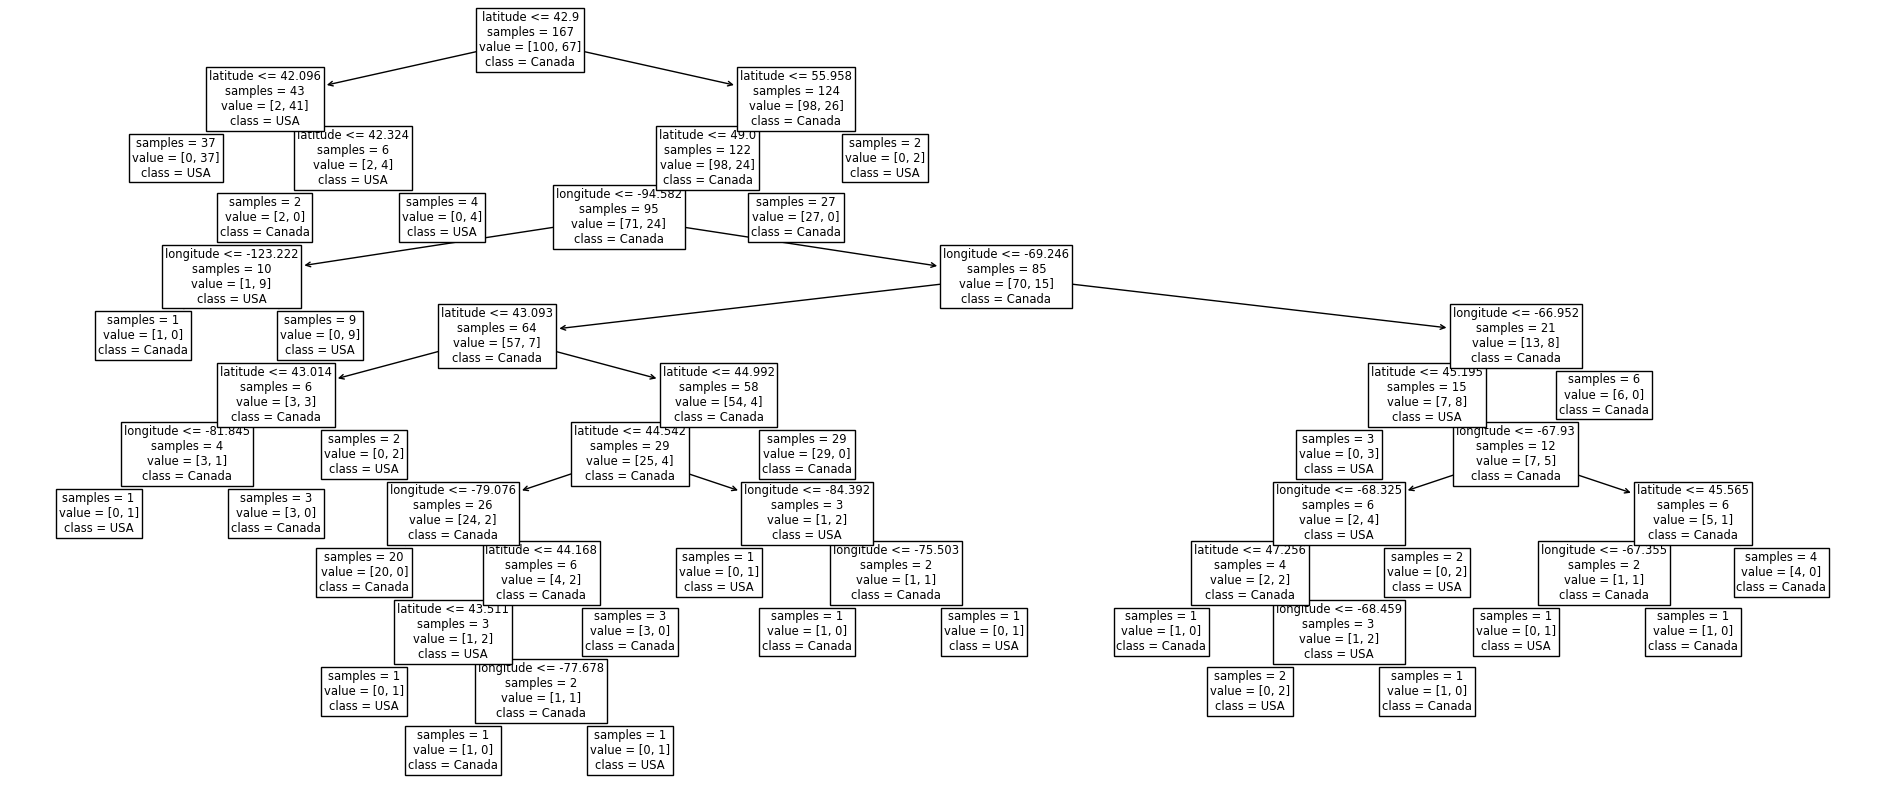

In [21]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

plot_tree(
    model,
    feature_names=X_train.columns,
    class_names=y_train.unique(),
    impurity=False,
    ax=plt.subplots(figsize=(24, 10))[1]
);

Let's see how on model scores on the training data and the test data.

In [22]:
print("Train score: " + str(round(model.score(X_train, y_train), 2)))
print("Test score: " + str(round(model.score(X_test, y_test), 2)))

Train score: 1.0
Test score: 0.74


For this tree, the training score is 1.0 and the test score is only 0.71.  

The model does not perform quite as well on data that it has not seen, i.e. it is very specific to the training data and does not generalize well.

To see this visually, let's look at the training and testing data with the decision boundaries made by the model.

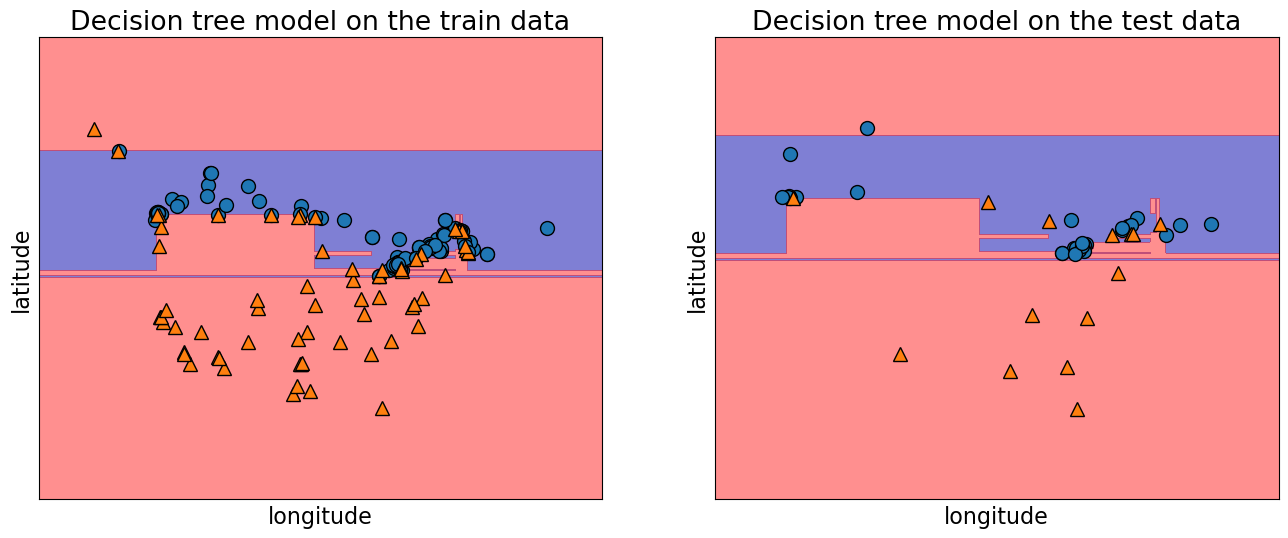

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={"xticks": (), "yticks": ()})
plot_tree_decision_boundary(
    model,
    X_train,
    y_train,
    eps=10,
    x_label="longitude",
    y_label="latitude",
    ax=ax[0],
    title="Decision tree model on the train data",
)
plot_tree_decision_boundary(
    model,
    X_test,
    y_test,
    eps=10,
    x_label="longitude",
    y_label="latitude",
    ax=ax[1],
    title="Decision tree model on the test data",
)

On the left and the right, we have the same boundaries. But different data being shown.

The model is getting 100 percent accuracy on the training and for that to happen, the model ends up being extremely specific.

The model got over complicated on the training data and this doesn’t generalize to the test data well.

In the plot on the right, we can see some red triangles in the blue area. That is the model making mistakes which explains the lower test accuracy.

### Parameters in `.train_test_split()`

- `test_size` - test split size (0-1)
- `train_size` - train split size (0-1) (only need to specify one if these
- `random_state` - keeps the split randomization consistent between runs

In [24]:
train_df, test_df = train_test_split(cities_df, test_size = 0.2, random_state = 123)

In [25]:
train_df, test_df = train_test_split(cities_df, train_size = 0.8, random_state = 123)

In [26]:
train_df, test_df = train_test_split(cities_df, test_size = 0.2, train_size = 0.8, random_state = 123)

There is no hard and fast rule on the split sizes should we use. Some common splits are 90/10, 80/20, 70/30 (training/test).

In the above example, we used an 80/20 split.

But there is a trade-off:
- More training -> More information for our model. 
- More test -> Better assessment of our model.

Now let's look at the random_state argument:

The random_state argument controls this shuffling and without this argument set, each time we split our data, it will be split in a different way.

In [27]:
train_df, test_df = train_test_split(cities_df, test_size = 0.2)
train_df

,longitude,latitude,country
132,-78.8630,43.9177,Canada
64,-119.7848,36.7394,USA
50,-77.0366,38.8950,USA
12,-82.4405,42.9816,USA
142,-123.1374,49.1632,Canada
...,...,...,...
185,-71.3998,46.8884,Canada
161,-60.1941,46.1380,Canada
49,-104.9849,39.7392,USA
71,-78.6391,35.7804,USA


We set this to add a component of reproducibility to our code and if we set it with a `random_state` when we run our code again it will produce the same result. 

In [28]:
train_df_rs5, test_df_rs5 = train_test_split(cities_df, test_size = 0.2, random_state = 42)
train_df_rs5

,longitude,latitude,country
150,-79.2441,43.1580,Canada
96,-76.3019,44.2110,Canada
199,-122.9109,49.2068,Canada
68,-94.5781,39.1001,USA
156,-72.5565,46.3327,Canada
...,...,...,...
106,-67.4253,45.5672,Canada
14,-78.8784,42.8867,USA
92,-83.0353,42.3171,Canada
179,-121.9514,49.1577,Canada


## Validation data for hyperparameter optimization

We have seen that letting the model set the hypterparameters (such as max_depth) in an unconstrained way, will cause it to become very specific to the training data. How can we come up with a good way to find which hyperparameters produce the best generalized model (also called **hyperparameter optimization**)?      
 
It's a good idea to have separate data for tuning the hyperparameters of a model that is not the test set. Enter, the ***validation*** set. 

So we actually want to split our dataset into 3 splits: train, validation, and test.

<img src='imgs/train-valid-test-split.png' width="100%" />


***Note: There isn't a good consensus on the terminology of what is validation and what is test data.***

We use: 
- **training data**: The data used when fitting to find the best model parameters.

- **validation data**: Data where we have access to the target values, but unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  This evaluation is still biased as skill on the validation dataset is incorporated into the model hyperparameter configuration.

- **test data** (also called holdout data): Data where we have access to the target values, but in this case, unlike training and validation data, we neither use it in training nor hyperparameter optimization and only use it **once** to evaluate the performance of the best performing model on the validation set. We lock it in a "vault" until we're ready to evaluate and it gives a more unbiased performance score than the validation score since the model configuration has not been tweaked to perform well on the test data in any way.

## "Deployment" data

What's the point of making models? 
 > We want to predict something which we do not know the answer to, so we do not have the target values and we only have the features.

After we build and finalize a model, we deploy it, and then the model is used with data in the wild.

We will use **deployment data** to refer to data, where we do not have access to the target values.

Deployment score is the thing we really care about; it is the performance of the final model on the data in production.

We use validation and test scores as proxies for the deployment score, and we hope they are similar.

So, if our model does well on the validation and test data, we hope it will do well on deployment data.

## Let's Practice 

1\. When is the most optimal time to split our data?     
2\. Why do we split our data?    
3\. Fill in the table below:    

| datasets   | `.fit()` | `.score()` | `.predict()` |
|------------|:--------:|:----------:|:------------:|
| Train      |    ✔️     |         |             |
| Validation |          |          |            |
| Test       |          |       |          |
| Deployment |          |            |            |


```{admonition} Solutions!
:class: dropdown

1. Before we visualize/explore it.

2. To help us assess how well our model generalizes.

3. Fill in the table below:

| datasets   | `.fit()` | `.score()` | `.predict()` |
|------------|:--------:|:----------:|:------------:|
| Train      |    ✔️    |   ✔️      |   ✔️         |
| Validation |          |   ✔️       |     ✔️      |
| Test       |          |    Once    |   Once       |
| Deployment |          |            |      ✔️      |

```

## Cross-validation


<!-- <img src='imgs/train-valid-test-split.png' width="100%" /> -->

Problems with having a single train-validation split:

- Only using a portion of your full data set for training/validation (data is our most precious resource!!!)
- If your dataset is small you might end up with a tiny training/validation set
- Might be unlucky with your splits such that they don't well represent your data (shuffling data, as is done in `train_test_split()`, is not immune to being unlucky!)

There must be a better way! 

<!-- <img src="https://media.giphy.com/media/i4gLlAUz2IVIk/giphy.gif"  width = "50%" alt="404 image" /> -->

There is! The answer to our problem is called.....

**Cross-validation** (CV) or **𝑘-fold cross-validation**.
In cross-validation,
we perform several training-validation splits and train and evaluate our model across all of them
to find the hyperparameters that performs the best on the data in general.

<img src='imgs/cross-validation.png' width="100%">

- We still have the test set here at the bottom locked away that we will not touch until the end.
- But, we split the training data into $k$ folds ($k>2$, often $k=10$). In the graphic above $k=4$.
- Each "fold" gets a turn at being the validation set.
- Each round will produce a score so after 𝑘-fold cross-validation, it will produce 𝑘 scores. We usually average over the 𝑘 results.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.
- We can get now a more “robust” score on unseen data since we can see the variation in the scores across folds.  


Note that for the same reason as we perform CV with the validation dataset,
we might also perform it with the test data set.
This is referred to as nested CV,
as it includes one outer CV loop for splitting the test data from the validation + training data,
and one inner CV loop for splitting the validation data from the training data
This can be a good idea in practice,
especially if your sample dataset is small,
but it is not as commonly used
as CV for only the validation-training split.

## Cross-validation using `sklearn`

There are 2 ways we can do cross-validation with `sklearn`:
- `.cross_val_score()`
- `.cross_validate()`

Before doing cross-validation we still need to split our data into our training set and our test set and separate the features from the targets. 
So using our `X` and `y` from our Canadian/United States cities data we split it into train/test splits. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)

### `cross_val_score`


In [30]:
model = DecisionTreeClassifier(max_depth=4)
cv_score = cross_val_score(model, X_train, y_train, cv=10)
cv_score

array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
       0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ])

In [31]:
print(f"Average cross-validation score = {np.mean(cv_score):.2f}")
print(f"Standard deviation of cross-validation score = {np.std(cv_score):.2f}")

Average cross-validation score = 0.84
Standard deviation of cross-validation score = 0.09


Once, we've imported `cross_val_score` we can make our model and call our model, the feature object and target object as arguments. 

- `cv` determines the cross-validation splitting strategy or how many "folds" there are.

- For each fold, the model is fitted on the training portion and scores on the validation portion.

- The output of `cross_val_score()` is the validation score for each fold. 

### `cross_validate`

- Similar to `cross_val_score` but more informative.
- Lets us access training ***and*** validation scores using the parameter `return_train_score`.
- Note: in the dictionary output `test_score` and `test_time` refers to *validation score* and *validation time*

In [32]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
scores

{'fit_time': array([0.00254798, 0.00328088, 0.00119495, 0.00120592, 0.00115728,
        0.00106502, 0.00119925, 0.00124025, 0.00112414, 0.00105286]),
 'score_time': array([0.00311804, 0.00144911, 0.00078106, 0.00078511, 0.00072765,
        0.00072098, 0.00077701, 0.0007658 , 0.00071788, 0.00079417]),
 'test_score': array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
        0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ]),
 'train_score': array([0.91333333, 0.90666667, 0.90666667, 0.9       , 0.90666667,
        0.91333333, 0.92      , 0.90066225, 0.90066225, 0.90066225])}

We can wrap this in a dataframe for easier reading.

In [33]:
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_score,train_score
0,0.002548,0.003118,0.764706,0.913333
1,0.003281,0.001449,0.823529,0.906667
2,0.001195,0.000781,0.705882,0.906667
3,0.001206,0.000785,0.941176,0.900000
4,0.001157,0.000728,0.823529,0.906667
5,0.001065,0.000721,0.823529,0.913333
6,0.001199,0.000777,0.705882,0.920000
7,0.001240,0.000766,0.937500,0.900662
8,0.001124,0.000718,0.937500,0.900662
9,0.001053,0.000794,0.937500,0.900662


In [34]:
scores_df.mean()

fit_time       0.001507
score_time     0.001064
test_score     0.840074
train_score    0.906865
dtype: float64

In [35]:
scores_df.std()

fit_time       0.000764
score_time     0.000754
test_score     0.094993
train_score    0.006822
dtype: float64

```{important}
Keep in mind that cross-validation does not return a model. It is not a way to build a model that can be applied to new data. The purpose of cross-validation is to **evaluate** how well the model will generalize to unseen data. 
```

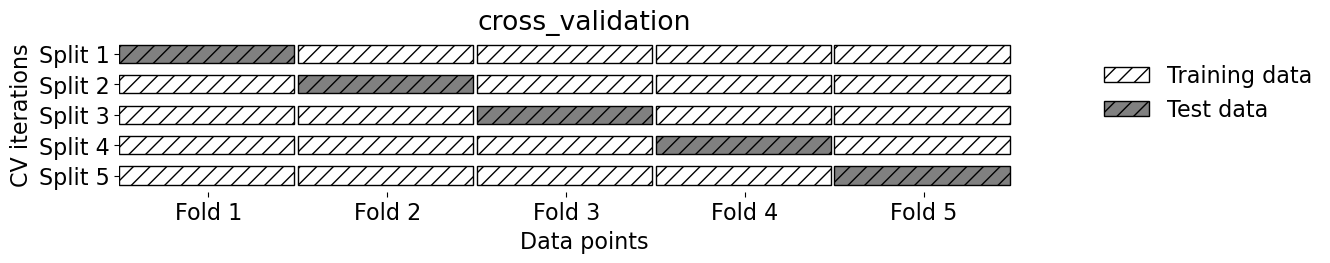

In [36]:
mglearn.plots.plot_cross_validation()

## Our typical supervised learning set up is as follows: 

1. Given training data with `X` and `y`.
2. We split our data into `X_train, y_train, X_test, y_test`.
3. Hyperparameter optimization using cross-validation on `X_train` and `y_train`. 
4. We assess the best model using  `X_test` and `y_test`.
5. The **test score** tells us how well our model generalizes.
6. If the **test score** is reasonable, we deploy the model.

## Let's Practice 

1\. We carry out cross-validation to avoid reusing the same validation set again and again. Let’s say you do 10-fold cross-validation on 1000 examples. For each fold, how many examples do you train on?    
2\. With 10-fold cross-validation, you split 1000 examples into 10-folds. For each fold, when you are done, you add up the accuracies from each fold and divide by what?     

**True/False:**  

3\. 𝑘-fold cross-validation calls fit 𝑘 times and predict 𝑘 times.


```{admonition} Solutions!
:class: dropdown
1. 900
2. 10
3. True
```

## Overfitting and Underfitting

### Types of scores 
We've talked about the different types of splits, now we are going to talk about their scores. 

- **Training score**: The score that our model gets on the same data that it was trained on. (seen data - training data) 
- **Validation score**: The mean validation score from cross-validation).
- **Test score**: This is the score from the data that we locked away. 

### Overfitting

- Overfitting occurs when our model is overly specified to the particular training data and often leads to bad results.
- Training score is high but the validation score is much lower.  
- The gap between train and validation scores is large.
- It's usually common to have a bit of overfitting (only a bit!) 
- This produces more severe results when the training data is minimal or when the model’s complexity is high.

In [37]:
model = DecisionTreeClassifier()
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002141,0.000836,0.647059,1.0
1,0.001185,0.000730,0.764706,1.0
2,0.001219,0.000774,0.764706,1.0
3,0.001242,0.000725,0.941176,1.0
4,0.001146,0.000865,0.882353,1.0
5,0.001254,0.000792,0.823529,1.0
6,0.001252,0.000751,0.705882,1.0
7,0.001143,0.000721,0.812500,1.0
8,0.001196,0.000822,0.937500,1.0
9,0.001248,0.000824,0.812500,1.0


In [38]:
print("Train score: " + str(round(scores["train_score"].mean(), 2)))
print("Validation score: " + str(round(scores["test_score"].mean(), 2)))

Train score: 1.0
Validation score: 0.81


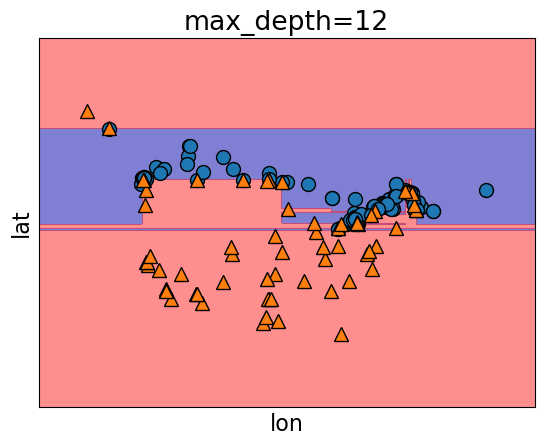

In [39]:
model.fit(X_train, y_train)
plot_tree_decision_boundary(
    model,
    X_train,
    y_train,
    eps=10,
    x_label="lon",
    y_label="lat",
)

### Underfitting 

- Underfitting is somewhat the opposite of overfitting in the sense that it occurs when the model is not complex enough. 
- Underfitting is when our model is too simple (`DecisionTreeClassifier` with max_depth=1). 
- The model doesn't capture the patterns in the training data and the training score is not that high.
- Both train and validation scores are low and the gap between train and validation scores is low as well.

In [40]:
model = DecisionTreeClassifier(max_depth=1)

scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train score: " + str(round(scores["train_score"].mean(), 2)))
print("Validation score: " + str(round(scores["test_score"].mean(), 2)))

Train score: 0.83
Validation score: 0.81


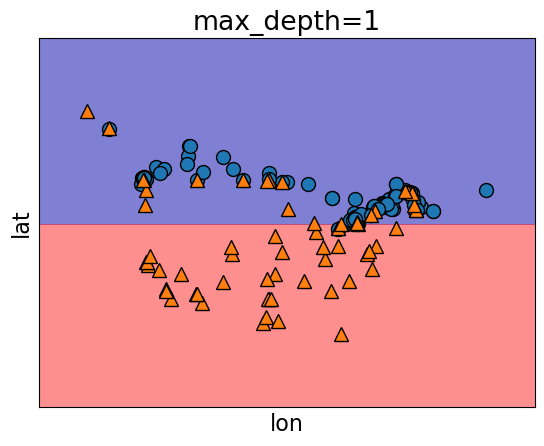

In [41]:
model.fit(X_train, y_train)
plot_tree_decision_boundary(
    model,
    X_train,
    y_train,
    eps=10,
    x_label="lon",
    y_label="lat",
)

Standard question to ask ourselves: 
***Which of these scenarios am I in?***

### How can we figure this out?

- If the training and validation scores are very far apart → more likely **overfitting**.     
    - Try decreasing model complexity.

- If the training and validation scores are very close together → more likely **underfitting**.  
    - Try increasing model complexity.

## The "Fundamental Tradeoff" of Supervised Learning

As model complexity increases:

$\text{Training score}$  ↑ and ($\text{Training score} − \text{Validation score}$) tend to also  ↑


If our model is too simple (underfitting) then we won't really learn any "specific patterns" of the training set. 

**BUT** 

If our model is too complex then we will learn unreliable patterns that get every single training example correct, and there will be a large gap between training error and validation error.

The trade-off is there is tension between these two concepts. 

When we underfit less, we overfit more. 

How do we know how much overfitting is too much and how much is not enough? 

### How to pick a model that would generalize better?

We can create a loop that tries different values of the hyperparameters to see which give the best results,
let's try this with a max depth from 1 to 20.

In [42]:
results_dict = {"depth": list(), "mean_train_score": list(), "mean_cv_score": list()}

for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_score"].append(scores["test_score"].mean())
    results_dict["mean_train_score"].append(scores["train_score"].mean())

results_df = pd.DataFrame(results_dict)
results_df

,depth,mean_train_score,mean_cv_score
0,1,0.834349,0.809926
1,2,0.844989,0.804044
2,3,0.862967,0.804412
3,4,0.906865,0.840074
4,5,0.918848,0.851838
5,6,0.930817,0.815074
6,7,0.954115,0.827941
7,8,0.973400,0.815441
8,9,0.980049,0.827574
9,10,0.994013,0.803309


In [52]:
source = results_df.melt(id_vars=['depth'] , 
                              value_vars=['mean_train_score', 'mean_cv_score'], 
                              var_name='score_type', value_name='accuracy')
chart1 = alt.Chart(source).mark_line().encode(
    alt.X('depth:Q', axis=alt.Axis(title="Tree Depth")),
    alt.Y('accuracy:Q', scale=alt.Scale(domain=[0.6, 1])),
    alt.Color('score_type:N', scale=alt.Scale(domain=['mean_train_score', 'mean_cv_score'],
                                           range=['teal', 'gold'])))

# Find the depth value that corresponds to the maximum mean_cv_score
max_cv_score_depth = results_df.loc[results_df['mean_cv_score'].idxmax(), 'depth']

# Add a vertical line at x=5
highlight = alt.Chart(pd.DataFrame({'x': [max_cv_score_depth]})).mark_rule(color='red', strokeDash=[2,1]).encode(x='x')

# Combine the charts
chart = chart1 + highlight
chart

alt.LayerChart(...)

- As we increase our depth (increase our complexity) our training data increases. 
- As we increase our depth, we overfit more, and the gap between the train score and validation score also increases... except  ... 

- There is a spot where the gap between the validation score and test score is the smallest while still producing a decent validation score.
- In the plot, this would be around `max_depth` is 5. 
- Commonly, we look at the cross-validation score and pick the hyperparameter with the highest cross-validation score. 

In [44]:
results_df.sort_values('mean_cv_score', ascending=False)

,depth,mean_train_score,mean_cv_score
4,5,0.918848,0.851838
3,4,0.906865,0.840074
6,7,0.954115,0.827941
8,9,0.980049,0.827574
7,8,0.973400,0.815441
11,12,1.000000,0.815074
5,6,0.930817,0.815074
0,1,0.834349,0.809926
15,16,1.000000,0.809191
14,15,1.000000,0.809191


Now that we know the best value to use for `max_depth`, we can build a new classifier setting `max_depth=5`, train it and now (only now) do we score our model on the test set.

In [45]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train);
print("Score on test set: " + str(round(model.score(X_test, y_test), 2)))

Score on test set: 0.81


- Is the test error comparable with the cross-validation error?
- Do we feel confident that this model would give a similar performance when deployed? 

## The Golden Rule 

- Even though we care the most about test error **THE TEST DATA CANNOT INFLUENCE THE TRAINING PHASE IN ANY WAY**. 
- We have to be very careful not to violate it while developing our ML pipeline. 
- Why? When this happens, the test data influences our training and the test data is no longer unseen data and so the test score will be too optimistic.
- Even experts end up breaking it sometimes which leads to misleading results and lack of generalization on the real data. 
    - https://www.theregister.com/2019/07/03/nature_study_earthquakes/
    - https://www.technologyreview.com/2015/06/04/72951/why-and-how-baidu-cheated-an-artificial-intelligence-test/
    
How do we avoid this? 

The most important thing is when splitting the data, we lock away the test set and keep it separate from the training data.

Forget it exists temporarily - kinda like forgetting where you put your passport until you need to travel. 

To summarize, the workflow we generally follow is:

- **Splitting**: Before doing anything, split the data `X` and `y` into `X_train`, `X_test`, `y_train`, `y_test` or `train_df` and `test_df` using `train_test_split`.  
- **Select the best model using cross-validation**: Use `cross_validate` with `return_train_score = True` so that we can get access to training scores in each fold. (If we want to plot train vs validation error plots, for instance.) 
- **Scoring on test data**: Finally, score on the test data with the chosen hyperparameters to examine the generalization performance.

## Let's Practice

**Overfitting or Underfitting**:     

1\. If our train accuracy is much higher than our test accuracy.     
2\. If our train accuracy and our test accuracy are both low and relatively similar in value.     
3\. If our model is using a Decision Tree Classifier for a classification problem with no limit on `max_depth`.    
 
**True or False**:  

4\. In supervised learning, the training score is always higher than the validation score.     
5\. The fundamental tradeoff of ML states that as training score goes up, validation score goes down.      
6\. More "complicated" models are more likely to overfit than "simple" ones.      
7\. If our training score is extremely high, that means we're overfitting.      

```{admonition} Solutions!
:class: dropdown
1. Overfitting
2. Underfitting
3. Likely overfitting
4. False
5. False
6. True
7. False
```

## Let's Practice - Coding 

Below is some starter code that creates your feature table and target column from the data from the `bball.csv` dataset (in the data folder).

In [46]:
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]

# Define X and y
X = bball_df.loc[:, ['height', 'weight', 'salary']]
y = bball_df['position']

1. Split the dataset into 4 objects: `X_train`, `X_test`, `y_train`, `y_test`. Make the test set 0.2 (or the train set 0.8) and make sure to use `random_state=7`.
2. Build a decision tree model with `max_depth=5`. 
3. Cross-validate using cross_validate() on the objects X_train and y_train specifying the model and making sure to use 10 fold cross-validation and `return_train_score=True`.
4. Convert the scores into a dataframe and save it in an object named scores_df.
5. Calculate the mean scores from cross validation.
6. Is your model overfitting or underfitting? 

**Solutions**

1\.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

2\.

In [48]:
dt5 = DecisionTreeClassifier(max_depth=5)

3\.

In [49]:
scores = cross_validate(dt5, X_train, y_train, cv=10, return_train_score=True)

4\.

In [50]:
scores_df = pd.DataFrame(scores)

5\.

In [51]:
scores_df.mean()

fit_time       0.001303
score_time     0.000778
test_score     0.844833
train_score    0.957826
dtype: float64

6\.

```{toggle}
It seems to be overfitting slightly since it is performing notably better on the training data.
```

## What We've Learned Today<a id="9"></a>

- The concept of generalization.
- How to split a dataset into train and test sets using `train_test_split` function.
- The difference between train, validation, test, and "deployment" data.
- The difference between training error, validation error, and test error.
- Cross-validation and use `cross_val_score()` and `cross_validate()` to calculate cross-validation error.
- Overfitting, underfitting, and the fundamental tradeoff.
- Golden rule and identify the scenarios when it's violated.